In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cross_validation import train_test_split

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df = pd.read_csv('./train.csv')
train, test = train_test_split(df, test_size=0.2)


In [3]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train['none'] = 1-train[label_cols].max(axis=1)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [4]:
train['comment_text'].fillna("cbarcelon", inplace=True)
test['comment_text'].fillna("cbarcelon", inplace=True)
classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
train_ratings = train[classes].values
test_ratings = test[classes].values

/usr/local/lib/python3.5/dist-packages/pandas/core/generic.py:3660: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [5]:
import re, string
re_tok = re.compile('([' + string.punctuation + '“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

In [6]:
n = train.shape[0]
vec = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize, min_df=11, max_df=0.7, strip_accents='unicode', use_idf=1, smooth_idf=1, sublinear_tf=1)
trn_term_doc = vec.fit_transform(train['comment_text'])
test_term_doc = vec.transform(test['comment_text'])

In [7]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from scipy import sparse
class NbSvmClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, C=1.0, dual=False, n_jobs=1):
        self.C = C
        self.dual = dual
        self.n_jobs = n_jobs

    def predict(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict(x.multiply(self._r))

    def predict_proba(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict_proba(x.multiply(self._r))

    def fit(self, x, y):
        # Check that X and y have correct shape
        y = y.values
        x, y = check_X_y(x, y, accept_sparse=True)

        def pr(x, y_i, y):
            p = x[y==y_i].sum(0)
            return (p+1) / ((y==y_i).sum()+1)

        self._r = sparse.csr_matrix(np.log(pr(x,1,y) / pr(x,0,y)))
        x_nb = x.multiply(self._r)
        self._clf = LogisticRegression(C=self.C, dual=self.dual, n_jobs=self.n_jobs).fit(x_nb, y)
        return self

In [8]:
model = NbSvmClassifier(C=1, dual=True, n_jobs=-1)
nbsvmpreds = np.zeros((len(test), len(label_cols)))
for i, j in enumerate(label_cols):
    print('fit', j)
    model.fit(trn_term_doc, train[j])
    nbsvmpreds[:,i] = model.predict_proba(test_term_doc)[:,1]

fit toxic


/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


fit severe_toxic
fit obscene
fit threat
fit insult
fit identity_hate


In [9]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, Input, Flatten
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout, AveragePooling1D, AveragePooling2D
from keras.preprocessing import text, sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [10]:
#Replace all blank comments with text in training set
#extract training comments 
comments_train = train["comment_text"].fillna("cbarcelon").values
#extract the toxciity ratings
classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
train_ratings = train[classes].values
test_ratings = test[classes].values
#extract test comments
comments_test = test["comment_text"].fillna("cbarcelon").values

#tokenizer the text
#vectorize text
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(list(comments_train))
tokenized_comments_train = tokenizer.texts_to_sequences(comments_train)
tokenized_comments_test = tokenizer.texts_to_sequences(comments_test)
#pad the text so each comment is uniform in length
X_train = sequence.pad_sequences(tokenized_comments_train, maxlen=100, truncating='post')
X_test = sequence.pad_sequences(tokenized_comments_test, maxlen=100,  truncating='post')

In [11]:
#load in glove embeddings
embeddings_index = dict()
f = open('glove.twitter.27B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 1193514 word vectors.


In [12]:
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [13]:
#define LSTM sequential model
lstm = Sequential()
lstm.add(Embedding(vocab_size, output_dim=100, weights=[embedding_matrix], input_length=100, trainable=True))
lstm.add(Bidirectional(LSTM(200, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)))
lstm.add(AveragePooling1D())
lstm.add(Bidirectional(LSTM(200, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)))
lstm.add(AveragePooling1D())
lstm.add(Bidirectional(LSTM(200, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)))
#lstm.add(AveragePooling1D())
lstm.add(Flatten())
lstm.add(Dropout(.5))
lstm.add(Dense(500, activation='relu'))
lstm.add(Dropout(.5))
lstm.add(Dense(6, activation = "sigmoid"))

lstm.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          13367900  
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 400)          481600    
_________________________________________________________________
average_pooling1d_1 (Average (None, 50, 400)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 50, 400)           961600    
_________________________________________________________________
average_pooling1d_2 (Average (None, 25, 400)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 25, 400)           961600    
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
__________

In [14]:
#compile the model
lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [15]:
#create checkpoint file
file_path = "weights_base.best.hdf5"
checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

#early stop checkpoint
early = EarlyStopping(monitor='val_loss', mode='min', patience=5)
callbacks_list = [checkpoint, early] 

In [16]:
#train/fit the model
lstm.fit(X_train, train_ratings, batch_size=250, epochs=4, validation_split=0.1, callbacks=callbacks_list)

Train on 69012 samples, validate on 7668 samples
Epoch 1/4
69012/69012 [==============================] - 220s - loss: 0.0818 - acc: 0.9732 - val_loss: 0.0540 - val_acc: 0.9795
Epoch 2/4
69012/69012 [==============================] - 208s - loss: 0.0523 - acc: 0.9812 - val_loss: 0.0505 - val_acc: 0.9817
Epoch 3/4
69012/69012 [==============================] - 194s - loss: 0.0467 - acc: 0.9827 - val_loss: 0.0525 - val_acc: 0.9810
Epoch 4/4
69012/69012 [==============================] - 205s - loss: 0.0422 - acc: 0.9838 - val_loss: 0.0496 - val_acc: 0.9822


In [17]:
#load the best weights
lstm.load_weights(file_path)

#make predictions on test set
lstmpred = lstm.predict(X_test)

In [18]:
lstmpred.shape

(19171, 6)

In [19]:
nbsvmpreds.shape

(19171, 6)

In [20]:
columns =[0,1,2,3,4,5]
ensemble = lstmpred.copy()
ensemble[columns] = (lstmpred[columns] + nbsvmpreds[columns]) / 2

In [21]:
ensemble[0]

array([ 0.00442134,  0.00050988,  0.00199274,  0.0002876 ,  0.00258671,
        0.00141049], dtype=float32)

In [22]:
lstmpred[0]

array([  2.34718973e-04,   6.90853739e-08,   2.49891236e-05,
         8.26695214e-07,   9.26668145e-06,   8.26879784e-07], dtype=float32)

In [23]:
nbsvmpreds[0]

array([ 0.00860796,  0.00101968,  0.0039605 ,  0.00057437,  0.00516415,
        0.00282015])

In [24]:
#log loss score function
from sklearn.metrics import log_loss
def calc_loss(y_true, y_pred):
    return np.mean([log_loss(y_true[:, i], y_pred[:, i]) 
                    for i in range(y_true.shape[1])])

In [25]:
score = calc_loss(test_ratings, nbsvmpreds)
print("nbsvm ", score)

nbsvm  0.0538449910671


In [26]:
score = calc_loss(test_ratings, lstmpred)
print("lstm ", score)

lstm  0.048896056333


In [27]:
score = calc_loss(test_ratings, ensemble)
print("ensemble ", score)

ensemble  0.0488916843013


In [28]:
comments_test[0]

'Sorry. If there is a forum was not started by me. It is here already in the promotion of the fact that blacks are incarcerated at a higher rate than whites. This is true. There is a reason for that. It is, however, omitted from here.'

In [29]:
lstmpred[0]

array([  2.34718973e-04,   6.90853739e-08,   2.49891236e-05,
         8.26695214e-07,   9.26668145e-06,   8.26879784e-07], dtype=float32)

In [30]:
x = 0
print(comments_test[x])
print(classes)
print(lstmpred[x])
print(test_ratings[x])

Sorry. If there is a forum was not started by me. It is here already in the promotion of the fact that blacks are incarcerated at a higher rate than whites. This is true. There is a reason for that. It is, however, omitted from here.
['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
[  2.34718973e-04   6.90853739e-08   2.49891236e-05   8.26695214e-07
   9.26668145e-06   8.26879784e-07]
[0 0 0 0 0 0]


In [35]:
def toxicity_scores(y_true, y_pred):
    tmp_score=0
    score=[]
    for i in range(y_true.shape[1]):
        tmp_score = np.mean([log_loss(y_true[:, i], y_pred[:, i])])
        score.append(tmp_score)
    return score    

In [38]:
nbsvmscores = toxicity_scores(test_ratings, nbsvmpreds)
print (nbsvmscores)
lstmscores = toxicity_scores(test_ratings, lstmpred)
print (lstmscores)
ensemblescores = toxicity_scores(test_ratings, ensemble)
print (ensemblescores)

[0.11107782629130709, 0.028725921024631444, 0.062971086932683107, 0.011588617040792259, 0.080670294201881293, 0.028036200911578404]
[0.10270607920423758, 0.023866310180808179, 0.052381490846634925, 0.013465191952131389, 0.070436058510211452, 0.030521207304078816]
[0.10268884946912027, 0.023866475781242128, 0.052374369031429689, 0.013465348730348379, 0.070433847803105326, 0.030521214992341207]


In [40]:
print(np.mean(nbsvmscores))
print(np.mean(lstmscores))
print(np.mean(ensemblescores))

0.0538449910671
0.048896056333
0.0488916843013


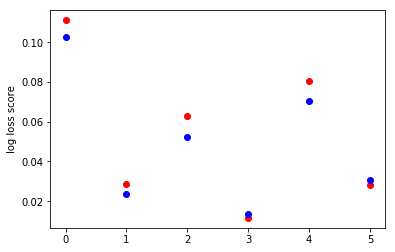

In [55]:
import matplotlib.pyplot as plt
plt.plot(nbsvmscores,'ro',lstmscores, 'bo')
plt.ylabel('log loss score')
plt.show()

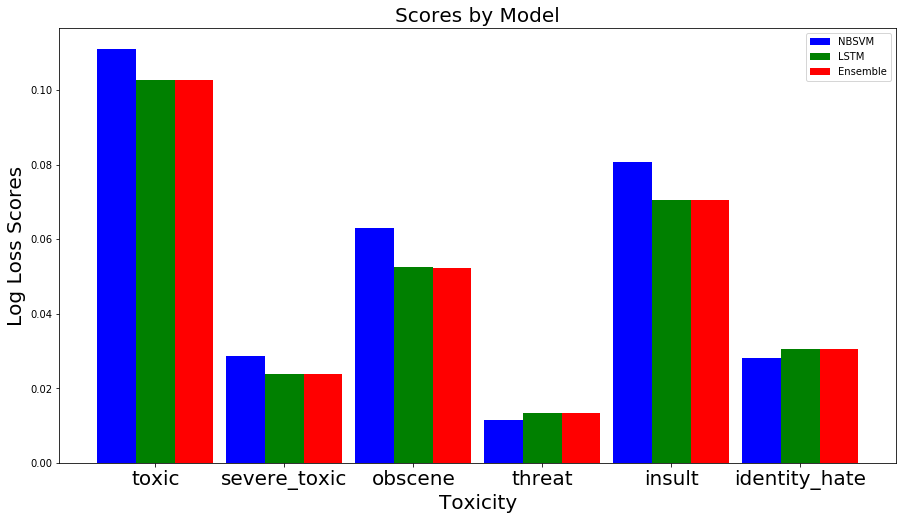

In [83]:
import numpy as np
import matplotlib.pyplot as plt
 
# data to plot
n_groups = 6
# create plot
fig, ax = plt.subplots(figsize=(15, 8))
index = np.arange(n_groups)
bar_width = 0.3
opacity = 1
 
rects1 = plt.bar(index, nbsvmscores, bar_width,
                 alpha=opacity,
                 color='b',
                 label='NBSVM')
 
rects2 = plt.bar(index + bar_width, lstmscores, bar_width,
                 alpha=opacity,
                 color='g',
                 label='LSTM')

rects3 = plt.bar(index + 2*bar_width, ensemblescores, bar_width,
                 alpha=opacity,
                 color='r',
                 label='Ensemble')
 
plt.xlabel('Toxicity', fontsize=20)
plt.ylabel('Log Loss Scores', fontsize=20)
plt.title('Scores by Model', fontsize=20)
plt.xticks(index + bar_width, classes, fontsize=20)
plt.legend()
 

plt.show()